In [1]:
%load_ext autoreload
%autoreload 2
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

In [2]:
# Plotting defaults
font_files = font_manager.findSystemFonts(fontpaths="/home/tsenga5/lib/fonts")
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

### Define paths and constants

In [3]:
base_path = "/home/tsenga5/mechint_regnet"

In [4]:
datasets = [
    "SPI1", "TAL/GATA", "E2F6", "JUND/TEAD", "REST", "SPI1/CTCF",
    "CTCF (HepG2)", "FOXA1 (HepG2)", "DNase (HepG2)", "DNase (HL-60)", "DNase (K562)"
]

In [5]:
model_stems = {
    "SPI1": os.path.join(base_path, "models/trained_models/simulated/spi1_exp_single/"),
    "TAL/GATA": os.path.join(base_path, "models/trained_models/simulated/tal_gata_exp_mix/"),
    "E2F6": os.path.join(base_path, "models/trained_models/simulated/e2f6_max_exp_coop/"),
    "JUND/TEAD": os.path.join(base_path, "models/trained_models/simulated/jund_tead_exp_hard_spacing/"),
    "REST": os.path.join(base_path, "models/trained_models/simulated/rest_exp_both/"),
    "SPI1/CTCF": os.path.join(base_path, "models/trained_models/simulated/spi1_ctcf_exp_repress/"),
    "CTCF (HepG2)": os.path.join(base_path, "models/trained_models/experimental/chipseq_ctcf_hepg2/"),
    "FOXA1 (HepG2)": os.path.join(base_path, "models/trained_models/experimental/chipseq_foxa1_hepg2/"),
    "DNase (HepG2)": os.path.join(base_path, "models/trained_models/experimental/dnase_hepg2/"),
    "DNase (HL-60)": os.path.join(base_path, "models/trained_models/experimental/dnase_hl60/"),
    "DNase (K562)": os.path.join(base_path, "models/trained_models/experimental/dnase_k562/")
}

In [6]:
mechint_model_stems = {dataset_key : os.path.join(path, "mechint_net") for dataset_key, path in model_stems.items()}
cnn_model_stems = {dataset_key : os.path.join(path, "standard_cnn") for dataset_key, path in model_stems.items()}
explainn_model_stems = {dataset_key : os.path.join(path, "explainn") for dataset_key, path in model_stems.items()}

In [7]:
figures_out_path = os.path.join(base_path, "figures/model_performance")
os.makedirs(figures_out_path, exist_ok=True)

### Import performance metrics

In [8]:
def import_best_perf(model_stem_path):
    """
    Given the path to the model stem (i.e. each subdirectory is a run),
    imports the output metrics and returns the performance of the run with
    the best test accuracy. Returns performance metrics in a dictionary.
    """
    best_metrics, best_acc = None, None
    for run_num in os.listdir(model_stem_path):
        metrics_path = os.path.join(model_stem_path, run_num, "metrics.json")
        if not os.path.exists(metrics_path):
            continue
        with open(metrics_path, "r") as f:
            metrics = json.load(f)
        acc = metrics["test_acc"]["values"][0]
        if not best_acc or acc > best_acc:
            best_metrics = {
                "acc": acc,
                "auroc": metrics["test_auroc"]["values"][0],
                "auprc": metrics["test_auprc"]["values"][0]
            }
            best_acc = acc
    return best_metrics

In [9]:
# Import performance metrics as dictionary for each dataset
mechint_perf = {
    dataset_key : import_best_perf(mechint_model_stems[dataset_key]) for dataset_key in datasets
}
cnn_perf = {
    dataset_key : import_best_perf(cnn_model_stems[dataset_key]) for dataset_key in datasets
}
explainn_perf = {
    dataset_key : import_best_perf(explainn_model_stems[dataset_key]) for dataset_key in datasets
}

In [10]:
# Collate into data table
data = []
col_names = [
    "Dataset",
    "ARGMINN Acc.", "Standard CNN Acc.", "ExplaiNN Acc.",
    "ARGMINN auROC", "Standard CNN auROC", "ExplaiNN auROC",
    "ARGMINN auRPC", "Standard CNN auRPC", "ExplaiNN auRPC"
]
for dataset_key in datasets:
    row = [dataset_key]
    for perf_key in ("acc", "auroc", "auprc"):
        row.extend([
            mechint_perf[dataset_key][perf_key],
            cnn_perf[dataset_key][perf_key],
            explainn_perf[dataset_key][perf_key]
        ])
    data.append(row)
perf_table = pd.DataFrame(data, columns=col_names)
perf_table

,Dataset,ARGMINN Acc.,Standard CNN Acc.,ExplaiNN Acc.,ARGMINN auROC,Standard CNN auROC,ExplaiNN auROC,ARGMINN auRPC,Standard CNN auRPC,ExplaiNN auRPC
0,SPI1,0.897656,0.886719,0.894531,0.955120,0.949302,0.950591,0.957591,0.956621,0.953976
1,TAL/GATA,0.883594,0.837500,0.856250,0.954163,0.909531,0.939343,0.959477,0.918252,0.941465
2,E2F6,0.907813,0.894531,0.871094,0.971467,0.947988,0.943877,0.975423,0.952079,0.944227
3,JUND/TEAD,0.987500,0.981250,0.984375,0.998704,0.997205,0.999094,0.998663,0.996792,0.999087
4,REST,0.882812,0.771094,0.856250,0.946907,0.835132,0.929023,0.940382,0.823552,0.926925
5,SPI1/CTCF,0.908594,0.860156,0.900000,0.967585,0.931294,0.955466,0.965430,0.928375,0.952943
6,CTCF (HepG2),0.768719,0.775337,0.781590,0.847680,0.849678,0.859218,0.853961,0.851835,0.859755
7,FOXA1 (HepG2),0.728051,0.734297,0.730193,0.805123,0.808602,0.810329,0.798094,0.805895,0.803848
8,DNase (HepG2),0.729888,0.730097,0.741407,0.816377,0.812488,0.823735,0.814942,0.809240,0.817548
9,DNase (HL-60),0.752855,0.759516,0.768932,0.832753,0.842123,0.852567,0.826047,0.839490,0.847409


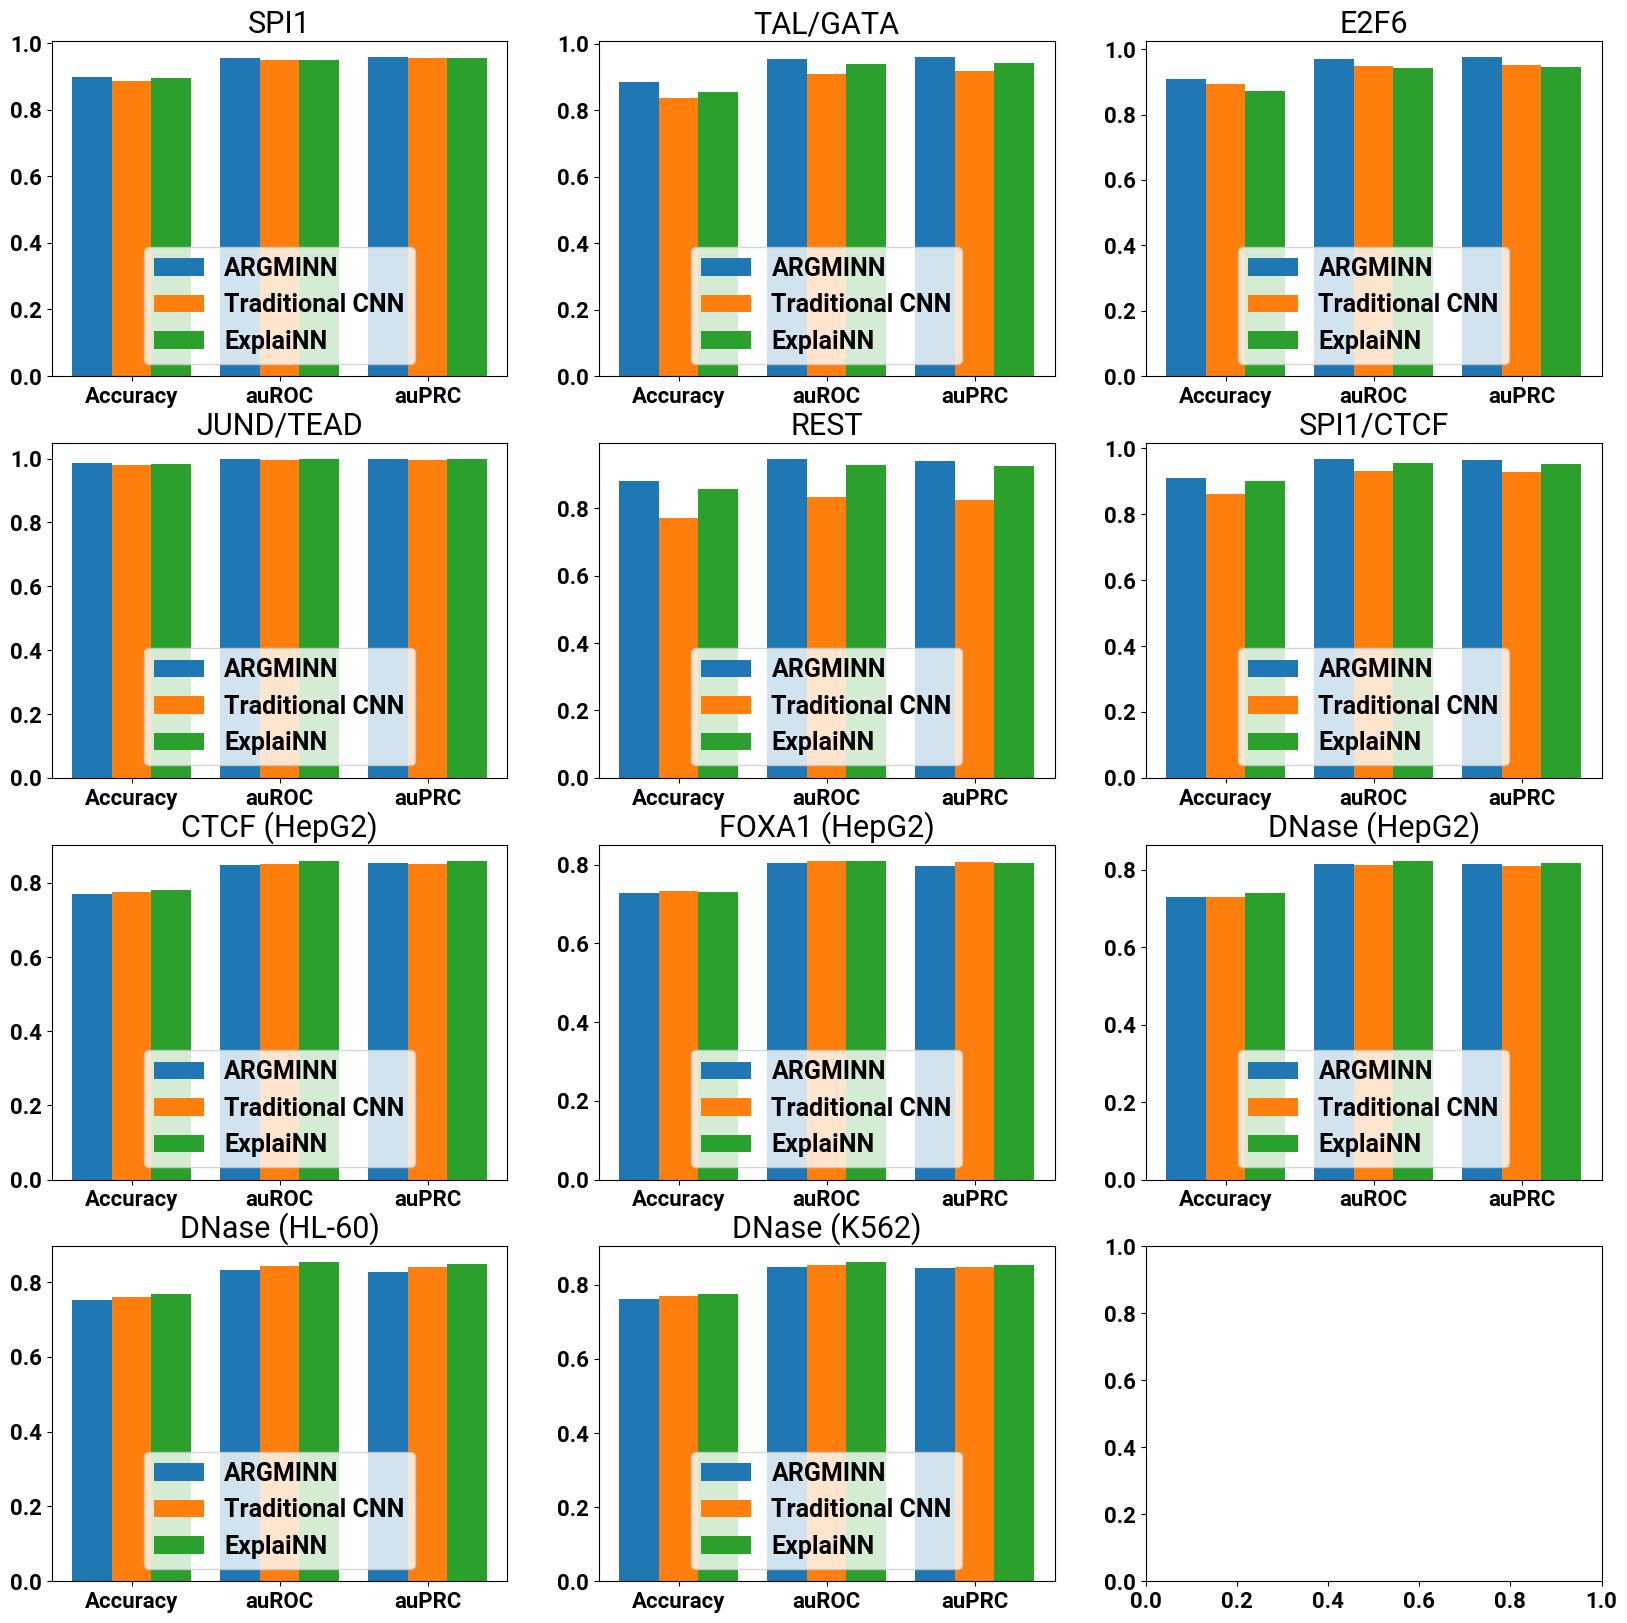

In [11]:
# Make plot
num_cols = 3
num_rows = int(np.ceil(len(datasets) / num_cols))
fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 5 * num_rows))

num_groups = 3
num_bars_per_group = 3
total_width = 0.8
x = np.arange(num_groups)

bar_labels = ["ARGMINN", "Traditional CNN", "ExplaiNN"]
group_labels = ["Accuracy", "auROC", "auPRC"]
perf_dicts = [mechint_perf, cnn_perf, explainn_perf]
metric_keys = ["acc", "auroc", "auprc"]

bar_width = total_width / num_bars_per_group
bar_width_offsets = -(total_width / 2) + \
    (total_width / num_bars_per_group * np.arange(num_bars_per_group)) + \
    (total_width / num_bars_per_group / 2)

for dataset_i, dataset_key in enumerate(datasets):
    i = dataset_i // num_cols
    j = dataset_i % num_cols

    for k in range(num_bars_per_group):
        ax[i, j].bar(
            x + bar_width_offsets[k],
            [perf_dicts[k][dataset_key][key] for key in metric_keys],
            bar_width, label=bar_labels[k]
        )
    ax[i, j].legend(loc="lower center")
    ax[i, j].set_xticks(range(num_groups))
    ax[i, j].set_xticklabels(group_labels)
    ax[i, j].set_title(dataset_key)
plt.show()
fig.savefig(os.path.join(figures_out_path, "performance_bar_plot.svg"), format="svg")